# Neural Nets Tutorial - Part 3

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)

## Linear Regression Refresh


Before we dive in, let's quickly refresh on linear regression.  Let's say we're trying to predict tomorrow's temperature (`tmax_tomorrow`) using today's max temperature (`tmax`), today's min temperature (`tmin`), and how much it rained today (`rain`).

We'll call tomorrow's temperature $y$, `tmax` $x_{1}$, `tmin` $x_{2}$, and `rain` $x_{3}$.

Then we can predict tomorrow's temperature using the equation $\hat{y}=w_{1}x_{1} + w_{2}x_{2} + w_{3}x_{4} + b$.  $\hat{y}$ is our prediction for tomorrow's temperature.  The $w$ values are called weights, and the $b$ value is called a bias.

We multiply each of our $x$ values by its corresponding weight, then add in the bias.  In the last lesson, we learned how to calculate the $w$ and $b$ values.

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import zutils as utils
import pprint as pp
import math

## Nonlinearity

A big limitation of linear regression is that the prediction will always be linearly related to the inputs.  In real-world data, this is rarely the case.

Let's say we're predicting `tmax_tomorrow` using only `tmax`.  Then the equation is simplified to $\hat{y}=w_{1}x_{1} + b$.  We can say that $w_{1}$ is `.82`, and $b$ is `11.99`.

Now, let's load in our data and graph `tmax_tomorrow` and `tmax`:

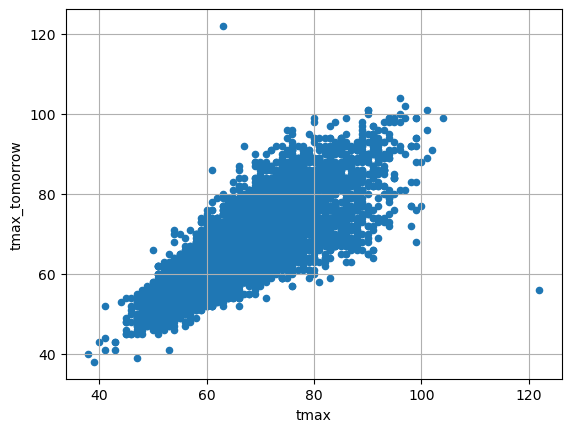

In [10]:
# Read in the data
data = pd.read_csv("data/clean_weather.csv", index_col=0)
# Fill in any missing values in the data with past values
data = data.ffill()

# Create a scatter plot of tmax and tmax_tomorrow
data.plot.scatter("tmax", "tmax_tomorrow")
plt.grid()

In [189]:
print('--> Basic statistics of data:')
print(data.describe())
print('--> Correlation coefficients:')
print(data.corr())

--> Basic statistics of data:
               tmax          tmin          rain  tmax_tomorrow
count  1.350900e+04  1.350900e+04  1.350900e+04   13509.000000
mean   8.331480e-16  3.787037e-16  2.244871e-15      66.057369
std    1.000037e+00  1.000037e+00  1.000037e+00       8.328832
min   -3.368735e+00 -7.277185e+00 -2.536613e-01      38.000000
25%   -7.272559e-01 -6.520163e-01 -2.536613e-01      60.000000
50%   -6.852603e-03  8.411356e-02 -2.536613e-01      66.000000
75%    5.934835e-01  8.202435e-01 -2.536613e-01      71.000000
max    6.716911e+00  2.734181e+00  1.957248e+01     122.000000
--> Correlation coefficients:
                   tmax      tmin      rain  tmax_tomorrow
tmax           1.000000  0.615604 -0.219941       0.818561
tmin           0.615604  1.000000 -0.019546       0.585572
rain          -0.219941 -0.019546  1.000000      -0.211799
tmax_tomorrow  0.818561  0.585572 -0.211799       1.000000


Text(0.5, 0, 'Temperature values')

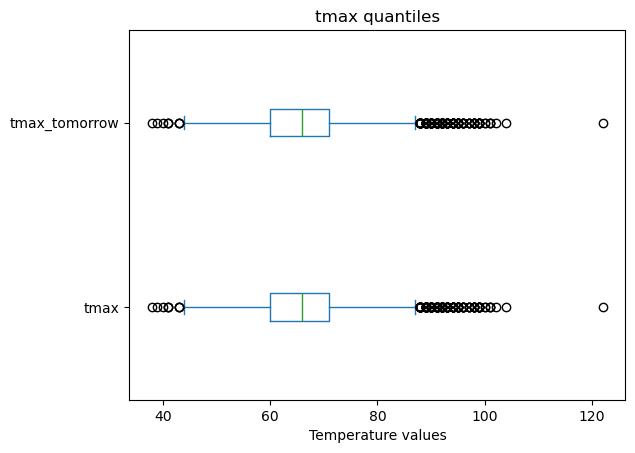

In [12]:
# make a boxplot of the temperatures
data.plot(kind='box', column=['tmax', 'tmax_tomorrow'], title='tmax quantiles', vert=False)
plt.xlabel('Temperature values')

As you can see above, the relationship between `tmax` and `tmax_tomorrow` isn't perfectly linear.  We can show this by drawing a linear regression line using $w_{1}$ equals `.82`, and $b$ equals `11.99`.

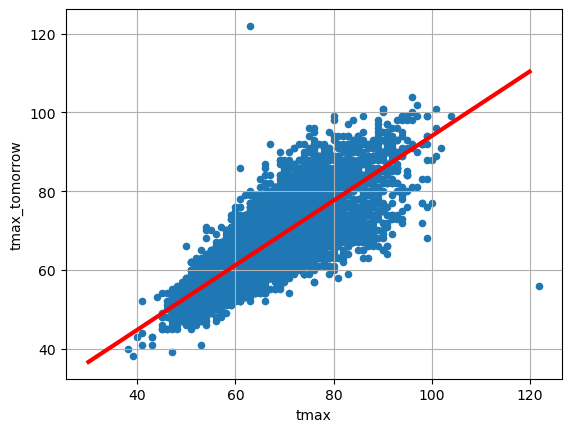

In [14]:
data.plot.scatter("tmax", "tmax_tomorrow")

# Calculate the prediction given our weight and bias
prediction = lambda x, w1=0.82, b=11.99: x * w1 + b

# Plot a linear regression line over our data
plt.plot([30, 120], [prediction(30),prediction(120)], 'red', linewidth=3)
plt.grid()
plt.show()

The line fits our data as well as a linear regression line can fit it (the mean squared error between the predictions and the actual `tmax_tomorrow` is as low as possible).

In [16]:
def mse(actual, predicted):
    # Calculate mean squared error
    return np.mean((actual - predicted) ** 2)

# Error with the weight of 0.82 and the bias of 11.99
print(mse(data["tmax_tomorrow"], prediction(data["tmax"])))

# Error with a small shift in our weight, to .83, and in our bias, to 12
print(mse(data["tmax_tomorrow"], prediction(data["tmax"], 0.83, 12.00)))

22.897335324598416
23.489303834480715


As we can see above, even a small shift in our weight and bias away from our optimal values increases error.

But the error is stil fairly high.  This is because our linear regression model isn't properly capturing the nonlinear interactions in our data.  For example, if `tmax` is `100`, maybe `tmax_tomorrow` will be `tmax` times `.7`, but if `tmax` is `50`, `tmax_tomorrow` might be `tmax` times `.8`.

This type of relationship is nonlinear - the ratio between `tmax` and `tmax_tomorrow` isn't always a constant value like `.82`.

If we plot tomorrow's temperature versus today's temperature, we can see that this is in fact the case:

data shape: (13509, 4)
point per bin: 450 for 30 bins


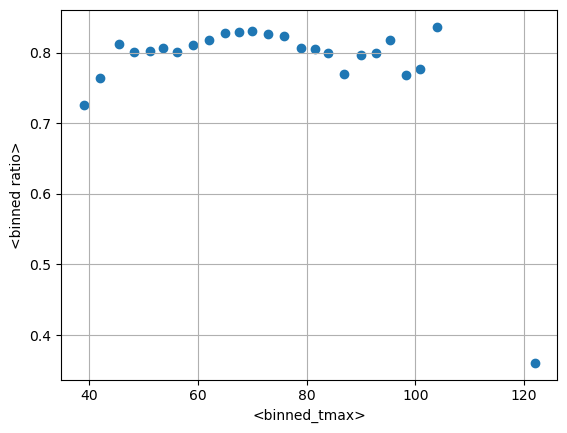

In [18]:
# Pandas cut() function is used to separate the array elements into different bins. 
# The cut function is mainly used to perform statistical analysis on scalar data. 

bins = 30
bias = 11.99 # just for testing

print('data shape:', data.shape)
point_per_bin = data.shape[0] // bins
print('point per bin:', point_per_bin, 'for', bins, 'bins')

# Cut our tmax range into 30 bins
tmax_bins = pd.cut(data["tmax"], 30)

# Pandas groupby is used for grouping the data according to the categories and applying a function to the categories. 
# It also helps to aggregate data efficiently. The Pandas groupby() is a very powerful function with a lot of variations. 
# It makes the task of splitting the Dataframe over some criteria really easy and efficient.

# Calculate the average ratio between tmax_tomorrow and tmax in each bin
# tmax_tomorrow = tmax * w + b => w = (tmax_tomorrow - b) / tmax

ratios = (data["tmax_tomorrow"] - bias ) / data["tmax"]
binned_ratio = ratios.groupby(tmax_bins, observed=False).mean()

# Calculate the average tmax in each bin
binned_tmax = data["tmax"].groupby(tmax_bins, observed=False).mean()

# Graph the tmax values versus the ratios, ratio should be constant for a linear problem
plt.scatter(binned_tmax, binned_ratio)
plt.xlabel('<binned_tmax>') # average of data
plt.ylabel('<binned ratio>') # average of weights
plt.grid()
plt.show()

## Activation Functions

Linear regression can't capture this kind of nonlinearity properly, but neural networks can!

Neural networks add to linear regression in three important ways:

- A nonlinear transformation on top of the linear transformation
- Multiple layers, which can capture interactions between features
- Multiple hidden units, which each have slightly different linear and nonlinear transformations

Let's discuss each of these concepts separately.  First, nonlinear transformations, which are called activation functions.  The most common activation function used in neural networks is called a rectified linear unit, or **relu**.  Conceptually, relu is pretty straightforward.  Any value below zero is set to zero, and any value above zero is passed through as normal.

All of our temperature values are above zero, but let's generate some new temperatures to visualize what relu does.

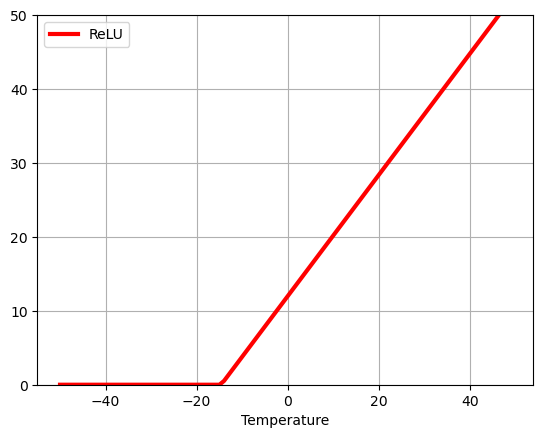

In [21]:
# Calculate the prediction given our weight and bias
prediction = lambda x, w1=0.82, b=11.99: x * w1 + b

def relu(model, inputs):
    return np.maximum(0, model(inputs))

# Generate a range of predictions between -50 and 50.
temperatures = np.arange(-50,50)

# Predict tmax_tomorrow given each of our input temperatures
plt.plot(temperatures, relu(prediction, temperatures), color='red', linewidth=3, label='ReLU')
plt.ylim(0,50)
plt.legend()
plt.grid()
plt.xlabel('Temperature')
plt.show()

You can see that any predictions below 0 are set to 0.  This creates a nonlinear relationship between the input and the prediction.  In this example, if $w_{1}x_{1} + b$ is less than `0`, then the output prediction will be `0`.  If $w_{1}x_{1} + b$ is greater than `0`, then the prediction will be $w_{1}x_{1} + b$.

This means that the prediction is no longer linearly related to the input.

The equation for this looks like:  $\large \hat{y}=relu(w_{1}x_{1} + b) $.

## Multiple Layers

Of course, if all we did was add relu, our error would increase a lot!  This is because we'd be making the same prediction for any temperature less than 0.  To fix this, we use multiple layers in our neural network.

A neural network with two layers would have the equation $\large \hat{y}=w_{2}(relu(w_{1}x_{1} + b)) + b_{2} $.

We won't use an activation function on our output layer - this is the layer that we'll use in our predictions, so we need to not modify the value of the prediction.  This way, we can use a nonlinearity in our network, while still outputting a full range of predictions.

You might notice that this doesn't fully solve the problem, though.  If our first layer $relu(w_{1}x_{1} + b)$ return `0`, then multiplying by $w_{2}$ will still result in `0`.  We'd only be adding in $b_{2}$ to generate our output.

Here's a concrete example, with $w_{2}$ set to `.5`, and $b_{2}$ set to `10`

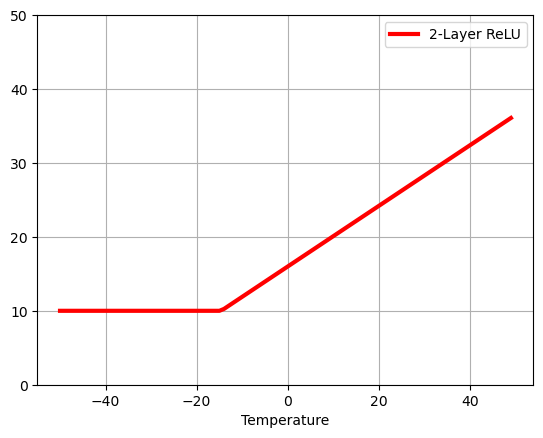

In [76]:
# Calculate the prediction given our weight and bias
prediction = lambda x, w1=0.82, b=11.99: x * w1 + b

def relu(inputs, w=0.82, b=11.99):
    return np.maximum(0, w*inputs + b)

# Generate a range of predictions between -50 and 50.
temperatures = np.arange(-50,50)
w2, b2 = 0.5, 10.0

outputs = relu(relu(temperatures), w2, b2)
plt.plot(temperatures, outputs, color='red', linewidth=3, label='2-Layer ReLU')
plt.ylim(0,50)
plt.legend()
plt.grid()
plt.xlabel('Temperature')
plt.show()

As you can see above, our predictions that are below zero have had $b_{2}$ of `10` added to them, but they're still all the same.  This is because if the output of `layer1` was `0`, then multiplying by $w_{2}$ still results in `0`.  So if the output of `layer1` is `0`, then `layer2` can only add in $b_{2}$, which is `10`.

This is a problem if we want to make accurate predictions - if `tmax` is below `0`, it's highly unlikely that `tmax_tomorrow` will always be `10`. To solve this problem we use multiple units in each layer, as described below:

## Multiple Units

We can solve this by adding multiple units at each layer.  This will basically be running linear regression multiple times, with different weights and biases.

For example, we can run linear regression twice, with slightly different weights and biases.

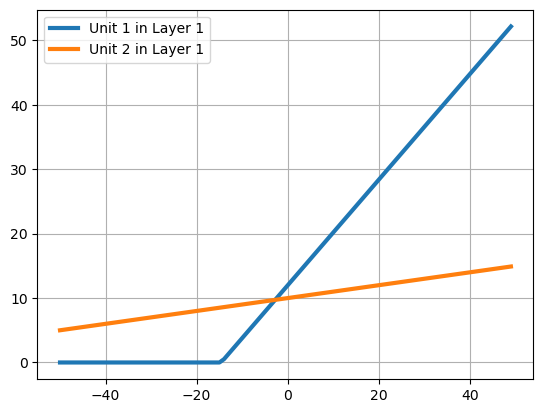

In [79]:
def relu(inputs, w=0.82, b=11.99):
    return np.maximum(0, w*inputs + b)

temps = np.arange(-50,50)
w2, b2 = 0.1, 10

# Plot our first regression line, with w1 of .82, and b of 11.99
plt.plot(temps, relu(temps), label='Unit 1 in Layer 1', linewidth=3)
plt.legend()
plt.grid()

# Plot our second regression line, with w1 of .1, and b of 10
plt.plot(temps, relu(temps, w2, b2), label='Unit 2 in Layer 1', linewidth=3)
plt.legend()
plt.show()

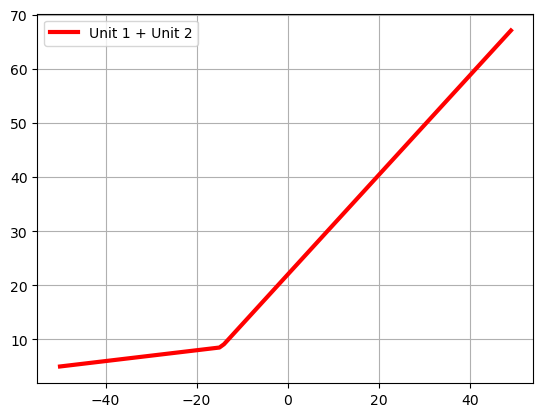

In [80]:
plt.plot(temps, relu(temps) + relu(temps, w2, b2), color='r', linewidth=3, label='Unit 1 + Unit 2')
plt.grid()
plt.legend()
plt.show()

Above, we plotted two lines.  The first line is the output of the first unit in the first layer of the neural network, and the second line is the output of the second unit in the first layer.

As you can see, the second unit stays positive across the range of the input temperatures, and thus can pass temperature information to the next layer.  So we maintain a nonlinear relationship between `tmax` and the output while not just passing `0` to the next layer for all temperatures below `0`.

We can then pass the output of both units into the second layer of the network to get a prediction.

Let's take a quick look at a diagram of this neural network:

<img src="images/dense/2layer_network.svg" width=600 />

Then we can code this network, where $w_{1}$ is `.82`, $w_{2}$ is `.1`, $w_{3}$ is `.5`, $w_{4}$ is `.2`, $b_{1}$ is `11.99`, $b_{2}$ is `10`, and $b_{3}$ is `5`.

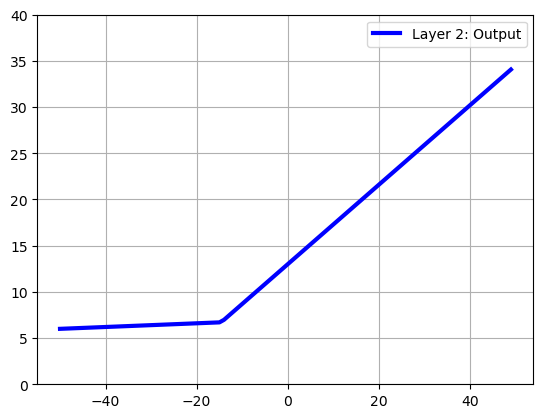

In [82]:
# Generate a range of predictions between -50 and 50.
temps = np.arange(-50,50)

w2, b2 = 0.1, 10
w3, b3 = 0.5, 5
w4 = 0.2

# Predict tmax_tomorrow given each of our input temps
# Output from unit 1 of layer 1
layer1_unit1 = relu(temps)

# Output from unit 2 of layer 1
layer1_unit2 = relu(temps, w2, b2)

# Output from layer 2 - multiply the outputs of layer 1 unit 1 and layer 1 unit 2 by the respective weights, and add the bias
layer2 = relu(layer1_unit1, w3, 0) + relu(layer1_unit2, w4, 0) + b3

# plot the Layer 2 output
plt.plot(temps, layer2, color='blue', linewidth=3, label='Layer 2: Output')
plt.grid()
plt.legend()
# Set the y axis of the plot to start at 0
plt.ylim((0,40))
plt.show()

In [95]:
def relu(inputs, w=0.82, b=11.99):
    return np.maximum(0, inputs)

def forward(inputs, weights, biases):
    return np.dot(inputs, weights) + biases

# Get 5 temperature values
inputs = np.array([[80], [90], [100], [-20], [-10]]) # the brackets in each value makes it a column vector

# Create the weight matrix, which is 1x2
L1_weights = np.array([[0.82, 0.1]])
# Create the 1x2 bias matrix
L1_bias = np.array([[12.0, 10.0]])

# Diagnostics
print('---------- DIAGNOSTICS ----------')
print('L1 weights:', L1_weights)
t = inputs @ L1_weights
print(t)
L1_output = t + L1_bias # bias broadcasted to 5x2
print()
print(L1_output)
print('--------- END DIAGNOSTICS ----------')
print()

L1_output = forward(inputs, L1_weights, L1_bias)
L1_activated = relu(L1_output)
print('*** Layer 1 Output ***')
print(L1_output)
print('*** Layer 1 Activated ***')
print(L1_activated)

# Output layer, layer 2
# create weights matrix 2x1
L2_weights = np.array([[0.5], [0.2]])
# create bias matrix 1x1
L2_bias = np.array([[5.0]])
# the input matrix is l1_output which is 5x2, so 5x2 @ 2x1 = 5x1 matrix
L2_output = forward(L1_activated, L2_weights, L2_bias)
print('*** Layer 2 Output ***')
print(L2_output)

---------- DIAGNOSTICS ----------
L1 weights: [[0.82 0.1 ]]
[[ 65.6   8. ]
 [ 73.8   9. ]
 [ 82.   10. ]
 [-16.4  -2. ]
 [ -8.2  -1. ]]

[[77.6 18. ]
 [85.8 19. ]
 [94.  20. ]
 [-4.4  8. ]
 [ 3.8  9. ]]
--------- END DIAGNOSTICS ----------

*** Layer 1 Output ***
[[77.6 18. ]
 [85.8 19. ]
 [94.  20. ]
 [-4.4  8. ]
 [ 3.8  9. ]]
*** Layer 1 Activated ***
[[77.6 18. ]
 [85.8 19. ]
 [94.  20. ]
 [ 0.   8. ]
 [ 3.8  9. ]]
*** Layer 2 Output ***
[[47.4]
 [51.7]
 [56. ]
 [ 6.6]
 [ 8.7]]


We then get a `5x1` output where each row corresponds to a prediction.  One nice way to think about neural network layers is that each layer generates new features in the data.  Our input had 1 feature `tmax`, and our first layer generated `2` new features to describe `tmax`.  Our second layer then compressed those `2` features back into one prediction for `tmax_tomorrow`.

One handy rule of thumb is that the number of rows in the weight matrix should equal the number of columns in the input matrix, and the number of columns in the weight matrix should equal the number of columns in the output matrix.  So in layer one, our weight matrix is `1x2` so we go from `1` feature in the input to `2` features in the output.

## Calculating W and B

We now know how to calculate the outputs of a neural network given $W$ and $B$.  This is called the forward pass of a neural network.

Let's learn how to calculate $W$ and $B$ from the data.  We'll be extending our work in the last lesson with gradient descent, which helps us find the $W$ and $B$ values that have the lowest error.  The difference this time is that we'll need to use backpropagation to transmit our loss gradient across multiple layers.

First of all, we need to calculate the loss between the actual `tmax_tomorrow` and our predictions.  We can do that using mean squared error, with the formula $\large \text{MSE}=(\hat{y} - y) ^ 2$.

Let's say these are our `tmax` and `tmax_tomorrow` values:

In [97]:
def mse(predicted, actual):
    return (predicted - actual) ** 2

def mse_grad(predicted, actual):
    # we drop the factor 2 from the derivative
    return predicted - actual

tmax = np.array([[80], [90], [100], [-20], [-10]])
tmax_tomorrow = np.array([[83], [89], [95], [-22], [-9]])

loss = mse(L2_output, tmax_tomorrow)
print('MSE values:')
print(loss)
output_grad = mse_grad(L2_output, tmax_tomorrow)
print('Gradient values:')
print(output_grad)

MSE values:
[[1267.36]
 [1391.29]
 [1521.  ]
 [ 817.96]
 [ 313.29]]
Gradient values:
[[-35.6]
 [-37.3]
 [-39. ]
 [ 28.6]
 [ 17.7]]


## Backpropagation Through Layers

Backpropagation will essentially reverse the forward pass to send the gradient to the various network parameters (weights and biases).  This gradient is how the network uses gradient descent to learn.

Here is the full forward pass of the network, with the operations we'll need to reverse:

<img src="images/dense/fwd.svg" width=600 />

And here is how we'll reverse them:

<img src="images/dense/bwd.svg" width=600 />

Now let's start reversing our operations, starting at the top of layer 2.

## Layer 2 Gradients

Now, we can calculate the gradient of our layer 2 parameters relative to our output gradient.  This is like undoing our forward pass, but with our error value as input.

We can first get our gradient with respect to our weights by multiplying the loss gradient by the output of layer 1:

<img src="images/dense/2layer_network.svg" width=600 />

In [101]:
# dMSE_dL2_output = L2_output - actual = output_grad
output_grad = mse_grad(L2_output, tmax_tomorrow)

# dMSE_dw = dMSE_doutput * dL2_output_dw
# L2_output = L2_input * W2 + B2 => dL2_output_dW2 = L2_input
# So, dMSE_dW2 = L2_input * output_grad = L1_activated * output_grad
print(L1_activated.shape, output_grad.shape)

# Note: Layer1 has two eights so the output L1_activated has a shape
# of len(inputs) x 2 = (5,2) and output_grad has (5,1) so we transpose L1_output (2,5) @ (5,1) = (2,1)
L2_w_grad = L1_activated.T @ output_grad  # L2_w_grad has shape (2,1)
print(L2_w_grad)

(5, 2) (5, 1)
[[-9561.64]
 [-1741.4 ]]


This is due to the chain rule of partial derivatives, which we covered in the last lesson.  If we want to find the gradient with respect to the layer 2 weights, or $\large \frac{\partial L}{\partial W_{2}}$, we can write it out as a chain of multiplications:

$$\large \frac{\partial L}{\partial W_{2}}=\partial L\frac{\partial (XW_{2})}{\partial W_{2}} = \large \frac{\partial L}{\partial (XW_{2})}\frac{\partial (XW_{2})}{\partial W_{2}}$$

In the equation above, $\partial L$ is really $\large \frac{\partial L}{\partial (XW_{2})}$, but we just simplify it to make it easier to read.  The partial derivative of the loss with respect to the layer 2 weights is the partial derivative of the loss with respect to the layer 2 output $XW_{2}$ times the partial derivative of $XW_{2}$ with respect to $W_{2}$.  We'll leave the bias out just to make things simpler.

We know that $\large \partial L$ is $XW_{2} - Y$. Now,  $XW_{2}$ is our output prediction, and the MSE gradient is `predicted - actual`.  Then we have to solve for $\large \frac{\partial (XW_{2})}{\partial W_{2}}$.  This is just $X$, since any change to $X$ will directly change the output $XW_{2}$.

So we can say that $\large \frac{\partial (XW_{2})}{\partial W_{2}} = X$, and that $\large \frac{\partial L}{\partial W_{2}} = (\partial L)\cdot X$.

If you ever want to verify derivatives, you can use the Python sympy library:

In [106]:
# dMSE/db = (dMSE/dL2_output) * (dL2_output/db) = output_grad * d(xw+b-y)/db = output_grad * 1
# the bias is always single value affecting all inputs by the same amount
# so we take the average over all inputs
L2_b_grad = np.mean(output_grad, axis=0) # note that output_grad is a 5x1 vector-matrix
print(L2_b_grad)

[-13.12]


<h4>To update our layer 2 weights and biases, we need to subtract the gradient from the $W$ and $B$ values, adjusted by the learning rate.  You may recall that the learning rate prevents us from making updates to the parameters that are too large (which will move us away from the area of lowest error):</h4>

In [108]:
learning_rate = 1.e-5

L2_weights_initial = L2_weights.copy()
L2_bias_initial = L2_bias.copy()
print(L2_weights_initial, L2_bias_initial)

L2_weights -= learning_rate * L2_w_grad
L2_bias -= learning_rate * L2_b_grad
print('new weights:')
print(L2_weights)
print('new bias:')
print(L2_bias)

[[0.5956164]
 [0.217414 ]] [[5.]]
new weights:
[[0.6912328]
 [0.234828 ]]
new bias:
[[5.0001312]]


## Layer 1 Gradients

To continue backpropagation, we now need to find our loss gradient with respect to our layer 1 outputs.  Our layer 1 outputs are scaled by the weights to get our layer 2 output:

<img src="images/dense/2layer_network.svg" width=600 />

In [110]:
# Compute the loss gradient w.r.t layer1 outputs
# dLoss/dL1_activated = (dLoss/dL2_output) * dL2_output/dL1_activated =
# output_grad * d(l1_activated*W2 + b2)/dL1_activated = 
# output_grad * W2 (W2 = layer2 weights)

# Calculate the gradient on the output of layer 1
L1_activated_grad = output_grad @ L2_weights.T

print('L1_activated_grad:\n', L1_activated_grad)
print('L1_output:\n', L1_output)

# dLoss/dW1 = (dLoss/dL1_activated) * (dL1_acivated/dW1) =
# (dLoss/dL1_activated) * d(inputs*W1 + B1)/dW1 =
# (dLoss/dL1_activated) * inputs =
# L1_activated_grad * inputs

# the gradient of ReLU is the heavyside function (step function)
L1_output_grad = L1_activated_grad * np.heaviside(L1_output, 0)
print('\nHeavyside function of L1_output')
print(np.heaviside(L1_output, 0))
utils.hr()
print('L1_output_grad:\n', L1_output_grad)

L1_activated_grad:
 [[-24.60788768  -8.3598768 ]
 [-25.78298344  -8.7590844 ]
 [-26.9580792   -9.158292  ]
 [ 19.76925808   6.7160808 ]
 [ 12.23482056   4.1564556 ]]
L1_output:
 [[77.6 18. ]
 [85.8 19. ]
 [94.  20. ]
 [-4.4  8. ]
 [ 3.8  9. ]]

Heavyside function of L1_output
[[1. 1.]
 [1. 1.]
 [1. 1.]
 [0. 1.]
 [1. 1.]]
----------------------------------------
L1_output_grad:
 [[-24.60788768  -8.3598768 ]
 [-25.78298344  -8.7590844 ]
 [-26.9580792   -9.158292  ]
 [  0.           6.7160808 ]
 [ 12.23482056   4.1564556 ]]


In [191]:
# Calculate gradients w.r.t weights and biases for layer 1
# Backpropagation
L1_w_grad =  inputs.T @ L1_output_grad
L1_b_grad = np.mean(L1_output_grad, axis=0)

# gradient descent
L1_weights -= L1_w_grad * learning_rate
L1_bias -= L1_b_grad * learning_rate

print('New L1_weights:\n', L1_weights)
print('New L1_biases:\n', L1_bias)

New L1_weights:
 [[0.89817981 0.12803705]]
New L1_biases:
 [[12.00014325 10.00003389]]


At this point, we can end backpropagation, since we've computed the gradients at each of our layers.

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)

## Backpropagation

Here is the algorithm we followed:

1. Run the network forward pass, and get the output:
2. Compute gradient with respect to the outputs of the network. (the `mse_grad` function)
3. For each layer in the network:
   - Compute the gradient with respect to the pre-nonlinearity output (if the layer has a nonlinearity)
   - Compute the gradient with respect to the weights
   - Compute the gradient with respect to the biases
   - Compute the gradient with respect to the inputs to the layer
4. Update the parameters in the network using gradient descent

For convenience, we combined step 4 into step 3.  But it's important to note that backpropagation is step 3 above, and gradient descent is step 4.  Splitting these steps up makes it easier to use variations of regular gradient descent to update the weights (like Adam or RMSProp).

Steps 3 and 4 are usually called the backward pass of a neural network.

Backpropagation and gradient descent are the most complicated parts of training neural networks.  Intuitively, backpropagation is about reversing the forward pass of the network so that we can figure out how to reduce error.  To do this, we pass the loss gradient from layer to layer (applying the chain rule).

## Batch Size

In the example above, we used a **batch size** of `5`.  This means that we did the forward and backward pass using `5` inputs from the training dataset.  Larger batch sizes will use more memory, since we need to create larger matrices.  But they will also run faster, since we can process more examples at once.

Batch size also affects gradient descent.  When we process `1` example at a time, we do a backward pass using the gradient of that single example.  With a larger batch size, we're averaging the gradient over every example in the batch when we update weights and biases.  This means that we may lose some accuracy in the updates when the batch size is too high.

When the batch size is the same as the rows in the training data, then the update process is called **batch gradient descent** (confusing, I know!).  Otherwise, it is called **stochastic gradient descent**.  Either way, we still use backpropagation to find the gradients.

## Putting it all together

We now know enough to train a neural network to predict the weather!

Let's first load our data and split it into 3 sets:

- A training set, which we'll use to train our algorithm
- A validation set, which we'll use to measure error during training
- A test set, which we'll use to evaluate the model after it has been fit

Creating separate sets like this helps us avoid overfitting, where our model looks great in training, but doesn't work in the real world.

In [114]:
from sklearn.preprocessing import StandardScaler
from scipy.interpolate import make_interp_spline

# Read in the data
data = pd.read_csv("data/clean_weather.csv", index_col=0)
# Fill in any missing values in the data with past values
data = data.ffill()

PREDICTORS = ["tmax", "tmin", "rain"]
TARGET = "tmax_tomorrow"

# Apply standardization to data values (Z score = (x - mean) /std)
# so they fit better to a normal distribution

# Scale our data so relu works better
# All temperature values in the original dataset are over 0, so relu won't do much for several epochs
# Scaling will make some of the input data negative
scaler = StandardScaler()
data[PREDICTORS] = scaler.fit_transform(data[PREDICTORS])

N1 = int(0.70 * len(data))
N2 = int(0.85 * len(data))

split_data = data.iloc[:N1], data.iloc[N1:N2], data.iloc[N2:]

# train_x contains [tmax, tmin, rain] values, train_y contains [tmax_tomorrow]

(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = [[d[PREDICTORS].to_numpy(), d[[TARGET]].to_numpy()] 
                                                            for d in split_data]

We'll train a neural network to predict `tmax_tomorrow` using `tmax`, `tmin`, and `rain`.

To train our neural network, we need 4 elements:

- A way to initialize our parameters (weights and biases for each layer)
- A `forward` pass that computes predictions using the parameters
- A loss function that measures the error of our predictions
- A `backward` pass that updates our parameters to reduce the loss

To initialize our weight parameters, we can use random initialization.  Random initialization helps the gradient descent algorithm descend to a global minimum efficiently (feel free to experiment with other initializations, like 0 or 1 to see what happens).

It's common to initialize the bias to be `1` or `0`.

We'll shrink the initial parameter values so we don't end up with predictions that are too large (this can cause gradient descent to take steps that are too large).

In [116]:
# random.rand(m, n) -> m x n matrix
# range(start, stop, step)
def init_layers(inputs):
    layers = []
    for i in range(1, len(inputs)):
        layers.append([
            np.random.rand(inputs[i-1], inputs[i]) / 5 - .1,
            np.ones((1,inputs[i]))
        ])
    return layers

# This will initialize weights and biases for a 3-layer neural network with 10 units in the first layer, 
# 10 in the second, and 1 in the final layer. The first number (3) is our number of input features
layer_conf = [3, 10, 10, 1]
layers = init_layers(layer_conf)
# for layer i = 0,1,2
# layers[i][0] = weights(i), layers[i][1] = biases(i)
#
print('Layer 1: 10 neurons\n', layers[0]) # first hidden layer
print('Layer 2: 10 neurons\n', layers[1]) # second hidden layer
print('Layer 3: 1 neuron\n', layers[2]) # output layer
print('Length of layers:', len(layers))

Layer 1: 10 neurons
 [array([[ 0.07930932, -0.02648763, -0.01282701,  0.07838467,  0.0612388 ,
         0.04077772, -0.07995462,  0.08389652,  0.04284826,  0.0997694 ],
       [-0.07011034,  0.07362521, -0.06750141,  0.02311191, -0.075236  ,
         0.06960165,  0.06146379,  0.01382015, -0.01856334, -0.0861666 ],
       [ 0.03948575, -0.00929146,  0.04441112,  0.07327647,  0.0951043 ,
         0.07116067, -0.09765718, -0.02800439,  0.04599811, -0.06567406]]), array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])]
Layer 2: 10 neurons
 [array([[ 0.00420732, -0.0891324 , -0.0600007 , -0.09629564,  0.05873954,
        -0.05521506, -0.03092966,  0.08561626,  0.04088288, -0.09363221],
       [-0.06706117,  0.02429568,  0.01544572, -0.05242144,  0.0868428 ,
         0.02279319,  0.00712656,  0.017982  ,  0.04602441, -0.037611  ],
       [-0.02035579, -0.05803125, -0.0627614 ,  0.08887448,  0.04791016,
        -0.00190824, -0.05451707, -0.0491287 , -0.08839417, -0.01311667],
       [-0.03764082, 

We initialize one weight matrix and one bias matrix for each of our layers.
In the forward pass of our network, we generate outputs for each layer by multiplying $W$ and $X$, then adding $B$.  If the layer is not our output layer, we also apply a nonlinearity (relu).
The output of the last layer is our prediction for `tmax_tomorrow`:

## Explanation of the chain-rule applied with multiple layers

<img src="images/nn-chain-rule.jpg" width=600 />

In [122]:
def init_layers(inputs):
    layers = []
    for i in range(1, len(inputs)):
        layers.append([
            np.random.rand(inputs[i-1], inputs[i]) / 5 - .1,
            np.ones((1,inputs[i]))
        ])
    return layers


def relu(X):
    return np.maximum(0, X)


def mse(actual, predicted):
    return (predicted - actual) ** 2


def mse_grad(actual, predicted):
    return predicted - actual


def forward(batch, layers):
    # hidden contains a list of lists with the inputs,
    # and the weights and biases of each layer
    hidden = [batch.copy()]
    for i in range(len(layers)):
        # multiply by weights (layers[i][0]) and add bias (layers[i][1])
        batch = np.matmul(batch, layers[i][0]) + layers[i][1]
        # do not apply relu on the output layer
        if i < len(layers) - 1:
            batch = relu(batch)
        # Store the forward pass hidden values for use in backprop
        hidden.append(batch.copy())
    return batch, hidden


def backward(layers, hidden, gradient, learning_rate):
    for i in range(len(layers)-1, -1, -1):
        # last layer does not have a ReLU activation
        if i != len(layers) - 1:
            gradient = np.multiply(gradient, np.heaviside(hidden[i+1], 0))

        w_grad = hidden[i].T @ gradient
        b_grad = np.mean(gradient, axis=0)

        layers[i][0] -= w_grad * learning_rate
        layers[i][1] -= b_grad * learning_rate
        
        # see the notes for the chain rule
        gradient = gradient @ layers[i][0].T
    return layers


def plot_data(X, Y, smooth=False, smooth_pts=50, x_label='epoch', y_label='MSE-train'):
    Y_min = min(Y)
    X_min = X[Y.index(Y_min)]
    
    deltaX = X[1] - X[0]
    
    annot_X = (max(X)-min(X)) // 2 + deltaX
    annot_Y = (max(Y)-min(Y)) // 2
    arrowprops = dict(facecolor='black', shrink=0.08)
    
    plt.figure(figsize=(9,5))
    if smooth:
        XY_Spline = make_interp_spline(X, Y, k=3)
        # Returns evenly spaced numbers
        # over a specified interval.
        Xs = np.linspace(min(X), max(X), smooth_pts)
        Ys = XY_Spline(Xs)
        plt.plot(Xs, Ys, linestyle='--', marker='o', markersize=7, markerfacecolor='k', 
                 color='b', label=y_label + ':splines fit', linewidth=2)
    else:
        plt.plot(X, Y, linestyle='--', marker='o', markersize=7, markerfacecolor='k', 
                 color='b', label=y_label, linewidth=2)

    plt.annotate(f'Min({y_label}) = {Y_min:.3f}', xy=[X_min, Y_min], xytext=[annot_X, annot_Y], 
                     arrowprops=arrowprops, fontsize=14)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.xticks(X, minor=False)
    #plt.ylim(bottom=20, top=40) # ylim(bottom=value1, top=value2)
    plt.grid()
    plt.legend()
    plt.show()

Finally, we'll write a loop that:

- Makes predictions for each batch (we'll use a batch size of `8`)
- Computes the gradient for each batch
- Updates the parameters based on the gradient

We will run the algorithm for several epochs - an epoch is each iteration over the training set.  Up to a point, more epochs will improve the accuracy.
We will print out the loss on the validation set regularly so we can monitor the loss.  We know we have too many epochs if the validation loss is increasing instead of decreasing.

Epoch: 0 Train MSE: 3393.4433507717727 Valid MSE: 1892.9432678008402
Epoch: 1 Train MSE: 411.667465598505 Valid MSE: 27.31980433166243
Epoch: 2 Train MSE: 23.188273061941903 Valid MSE: 21.263637716649676
Epoch: 3 Train MSE: 22.411127003855793 Valid MSE: 20.845140157716045
Epoch: 4 Train MSE: 22.19267711786779 Valid MSE: 20.769474005957406
Epoch: 5 Train MSE: 22.13663325469949 Valid MSE: 20.760777925863426
Epoch: 6 Train MSE: 22.121444190272815 Valid MSE: 20.76325784443894
Epoch: 7 Train MSE: 22.11636680611796 Valid MSE: 20.76605071010062
Epoch: 8 Train MSE: 22.113661841230623 Valid MSE: 20.767907230329023
Epoch: 9 Train MSE: 22.111677624293232 Valid MSE: 20.769233995647543
Epoch: 10 Train MSE: 22.109911543611492 Valid MSE: 20.77017006397817
Epoch: 11 Train MSE: 22.10837771269283 Valid MSE: 20.77090454570286
Epoch: 12 Train MSE: 22.106970313886972 Valid MSE: 20.7716771172815
Epoch: 13 Train MSE: 22.10557586491628 Valid MSE: 20.77235876035378
Epoch: 14 Train MSE: 22.10429841984044 Valid 

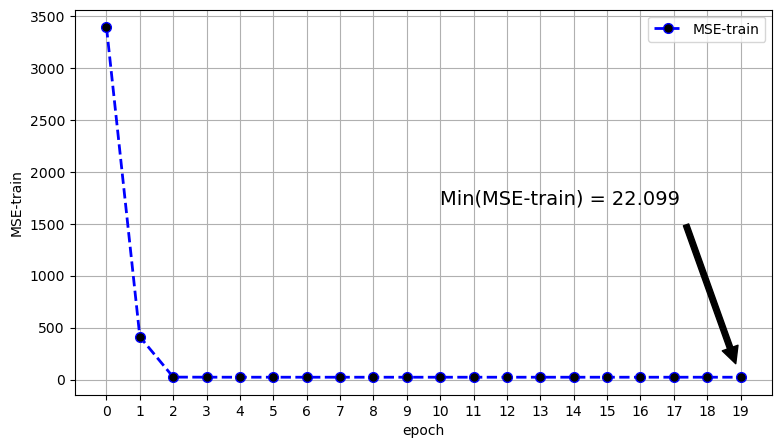

In [124]:
learning_rate = 1.0e-6
epochs = 20
batch_size = 10

np.random.seed(0)

layers = init_layers(layer_conf)

mse_values = []
epoch_values = []

for epoch in range(epochs):
    epoch_loss = []
    
    for i in range(0, train_x.shape[0], batch_size):
        x_batch = train_x[i:(i+batch_size)]
        y_batch = train_y[i:(i+batch_size)]
        
        pred, hidden = forward(x_batch, layers)
        # if i == 0: print(hidden)
        loss = mse_grad(y_batch, pred)
        epoch_loss.append(np.mean(loss ** 2))
        layers = backward(layers, hidden, loss, learning_rate)
    
    # check results for the validation dataset
    valid_preds, _ = forward(valid_x, layers)
    
    epoch_values.append(epoch)
    mse_values.append(np.mean(epoch_loss))
    print(f"Epoch: {epoch} Train MSE: {np.mean(epoch_loss)} Valid MSE: {np.mean(mse(valid_preds,valid_y))}")

plot_data(epoch_values, mse_values, smooth=False)

## Self-adjusting training loop

Epoch: 0 Train MSE: 3393.4433507717727 Valid MSE: 1892.9432678008402
Epoch: 1 Train MSE: 411.667465598505 Valid MSE: 27.31980433166243
Epoch: 2 Train MSE: 23.188273061941903 Valid MSE: 21.263637716649676
Epoch: 3 Train MSE: 22.411127003855793 Valid MSE: 20.845140157716045
Epoch: 4 Train MSE: 22.19267711786779 Valid MSE: 20.769474005957406
Epoch: 5 Train MSE: 22.13663325469949 Valid MSE: 20.760777925863426
Epoch: 6 Train MSE: 22.121444190272815 Valid MSE: 20.76325784443894


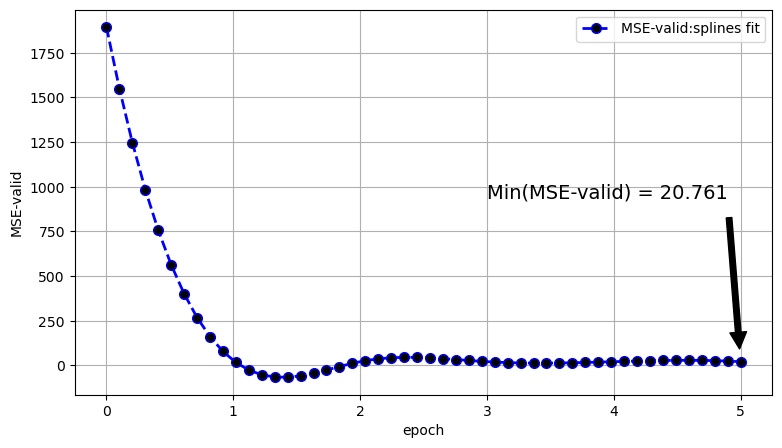

In [179]:
learning_rate = 1.0e-6
epochs = 20
batch_size = 10
delta_loss = 1.e-3

np.random.seed(0)

layers = init_layers(layer_conf)

mse_train = []
mse_valid = []
mse_test = []
epoch_values = []

epoch = 0
while epoch < epochs:
    epoch_loss = []
    
    for i in range(0, train_x.shape[0], batch_size):
        x_batch = train_x[i:(i+batch_size)]
        y_batch = train_y[i:(i+batch_size)]
        
        pred, hidden = forward(x_batch, layers)
        loss = mse_grad(y_batch, pred)
        epoch_loss.append(np.mean(loss ** 2))
        layers = backward(layers, hidden, loss, learning_rate)
        
    # check results for the validation dataset
    valid_preds, _ = forward(valid_x, layers)
    # check results against test dataset
    test_preds, _ = forward(test_x, layers)
    
    epoch_values.append(epoch)
    mse_train.append(np.mean(epoch_loss))
    mse_valid.append(np.mean(mse(valid_preds, valid_y)))
    mse_test.append(np.mean(mse(test_preds, test_y)))
        
    print(f"Epoch: {epoch} Train MSE: {np.mean(epoch_loss)} Valid MSE: {np.mean(mse(valid_preds,valid_y))}")
    
    if epoch >= 1:
        # if loss starts to increase, we have too many epochs, so stop iterating
        if mse_valid[epoch] - mse_valid[epoch-1] > delta_loss:
            mse_test = mse_test[:epoch]
            mse_train = mse_train[:epoch]
            mse_valid = mse_valid[:epoch]
            epoch_values = epoch_values[:epoch]
            break
    
    epoch += 1

plot_data(epoch_values, mse_valid, smooth=True, smooth_pts=50, y_label='MSE-valid')


In [183]:
import os
import sys

filename = 'regression-layers.npy'
cur_path = os.getcwd()
path_file = os.path.join(cur_path, 'data', filename)
print('File with trained hyper-parameters:', path_file)

np.save(path_file, np.array(layers, dtype=object), allow_pickle=True)
parameters = np.load(path_file, allow_pickle=True)

for i in range(len(parameters)):
    print(f'Loaded layer {str(i+1)} weights:\n', parameters[i][0])
    print(f'Loaded layer {str(i+1)} biases:\n', parameters[i][1])

File with trained hyper-parameters: F:\PYTHON WORKSHOP\ANN\data\regression-layers.npy
Loaded layer 1 weights:
 [[ 0.11078192  0.13119407  0.11199922  0.09710985  0.08016394  0.12051382
   0.07698398  0.17981027  0.202699    0.0749893 ]
 [ 0.07640534  0.01758586  0.02681736  0.09700662 -0.07180983 -0.06896114
  -0.08418694  0.08411386  0.07799082  0.09043823]
 [ 0.07013428  0.0384411  -0.0301277   0.03470621 -0.11931823  0.00547506
  -0.10933404  0.06338545 -0.0240733  -0.04170916]]
Loaded layer 1 biases:
 [[1.06421163 1.05225505 1.05508591 1.05218164 1.05729228 1.05558017
  1.05250762 1.06402382 1.07190831 1.06126695]]
Loaded layer 2 weights:
 [[0.34079267 0.3960341  0.35383828 0.30633785 0.22986668 0.33579467
  0.42466643 0.27279981 0.57626718 0.33772197]
 [0.35797318 0.32703985 0.40054634 0.20339366 0.35794661 0.34493856
  0.34245767 0.17401698 0.44832802 0.27272887]
 [0.40084955 0.32799036 0.45934949 0.21229329 0.26698753 0.24366719
  0.43176483 0.19937091 0.47943271 0.2494335 ]
 [0

### Matrix multiplication methods

In [ ]:
# Define two matrices for matrix multiplication
matrix_a = np.array([[1, 2, 3], [4, 5, 6]])
matrix_b = np.array([[7, 8], [9, 10], [11, 12]])

# Perform matrix multiplication
matmul_result = np.matmul(matrix_a, matrix_b)
dot_result = np.dot(matrix_a, matrix_b)
operator_result = matrix_a @ matrix_b

print("Matrix Multiplication:")
print(matmul_result)
print("Dot Product")
print(dot_result)
print('Operator Product')
print(operator_result)

![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)